In [1]:
import pandas as pd
import json
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from pydriller import Repository

# Zorgt dat grafieken direct zichtbaar zijn
%matplotlib inline

In [2]:



FOLDER_PATH = os.path.join('Databestanden', 'all.json')
ECOSYSTEM_NAME = "Python (PyPI)"

print(f"--- START MINING VOOR: {ECOSYSTEM_NAME} ---")
print(f"Map: {FOLDER_PATH}")

--- START MINING VOOR: Python (PyPI) ---
Map: Databestanden/all.json


In [3]:
def score_to_group(score):
    if score >= 9.0: return 'Critical'
    elif score >= 7.0: return 'High'
    elif score >= 4.0: return 'Medium'
    else: return 'Low'

def get_severity_group(entry, entry_id=""):
    """
    Bepaalt severity. Geeft 'None' terug voor Malware, 
    omdat we geen malware willen minen.
    """
    # 1. Malware negeren voor Mining
    if entry_id.startswith('MAL-'):
        return None 

    severity_str = None
    raw_sev = entry.get('severity')

    # 2. Check 'database_specific' (Cruciaal voor npm GHSA!)
    if 'database_specific' in entry:
        severity_str = entry['database_specific'].get('severity')

    # 3. Check root string
    if not severity_str and isinstance(raw_sev, str):
        severity_str = raw_sev

    # 4. Categoriseren op tekst
    if severity_str:
        s = severity_str.upper()
        if 'CRITICAL' in s: return 'Critical'
        if 'HIGH' in s: return 'High'
        if 'MODERATE' in s or 'MEDIUM' in s: return 'Medium'
        if 'LOW' in s: return 'Low'
    
    # 5. Categoriseren op score (lijst of getal)
    if isinstance(raw_sev, list):
        for item in raw_sev:
            if isinstance(item, dict) and isinstance(item.get('score'), (int, float)):
                return score_to_group(float(item['score']))
            if isinstance(item, dict) and item.get('type') in ['CVSS_V3', 'CVSS_V31']:
                 try: return score_to_group(float(item.get('score')))
                 except: pass

    if isinstance(raw_sev, (int, float)):
        return score_to_group(float(raw_sev))

    return None

In [4]:
candidates = {'Low': [], 'Medium': [], 'High': [], 'Critical': []}

if not os.path.exists(FOLDER_PATH):
    print(f"FOUT: Map niet gevonden: {FOLDER_PATH}")
else:
    files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.json')]
    total_files = len(files)
    print(f"Scannen van {total_files} bestanden op GitHub links...")

    counter = 0
    found_count = 0

    for filename in files:
        counter += 1
        if counter % 10000 == 0: print(f"   Gescand: {counter}/{total_files}...")

        if filename.startswith('MAL-'): continue

        try:
            with open(os.path.join(FOLDER_PATH, filename), 'r', encoding='utf-8') as f:
                entry = json.load(f)
                
                group = get_severity_group(entry, entry.get('id', filename))
                
                if group and 'references' in entry:
                    for ref in entry['references']:
                        url = ref.get('url', '')
                        # We zoeken specifieke commit links
                        if 'github.com' in url and '/commit/' in url:
                            candidates[group].append(url)
                            found_count += 1
                            break 
        except: continue

    print("-" * 30)
    print(f"Totaal GitHub fix-commits gevonden: {found_count}")
    for g, urls in candidates.items():
        print(f"  {g}: {len(urls)}")

Scannen van 17715 bestanden op GitHub links...
   Gescand: 10000/17715...
------------------------------
Totaal GitHub fix-commits gevonden: 2721
  Low: 262
  Medium: 1124
  High: 989
  Critical: 346


In [5]:
import math

def calculate_needed_sample(N, confidence_level=0.95, margin_of_error=0.10):
    """
    Berekent de steekproefgrootte n voor een populatie N.
    Standaard: 95% zekerheid, 10% foutmarge (om het haalbaar te houden voor mining).
    """
    if N == 0: return 0
    
    # Z-score voor 95% is 1.96
    Z = 1.96
    p = 0.5  # Worst-case schatting voor variantie (50%)
    e = margin_of_error
    
    # Formule van Cochran (aangepast voor eindige populatie)
    numerator = (Z**2 * p * (1-p)) / (e**2)
    n = numerator / (1 + ((numerator - 1) / N))
    
    return math.ceil(n)

In [6]:
if found_count == 0:
    print("Geen commits gevonden om te minen.")
else:
    to_mine = []
    print("\n--- STEEKPROEF BEREKENING (Stratified Sampling) ---")
    
    for g, urls in candidates.items():
        if urls:
            population_size = len(urls)
            
            # Hier berekenen we n specifiek voor DEZE groep
            needed_n = calculate_needed_sample(population_size, margin_of_error=0.10)
            
            # Veiligheidscheck: we kunnen niet meer minen dan we hebben
            # (Bijv. als formule 90 zegt, maar we hebben maar 50 links, pakken we er 50)
            final_n = min(len(urls), needed_n)
            
            print(f"Severity '{g}': Populatie={population_size} -> We minen er: {final_n}")
            
            # De daadwerkelijke loterij
            sample = random.sample(urls, final_n)
            for url in sample:
                to_mine.append({'group': g, 'url': url})

    print("-" * 40)
    print(f"Totaal te minen: {len(to_mine)} repositories.")
    print("-" * 40)


--- STEEKPROEF BEREKENING (Stratified Sampling) ---
Severity 'Low': Populatie=262 -> We minen er: 71
Severity 'Medium': Populatie=1124 -> We minen er: 89
Severity 'High': Populatie=989 -> We minen er: 88
Severity 'Critical': Populatie=346 -> We minen er: 76
----------------------------------------
Totaal te minen: 324 repositories.
----------------------------------------


In [7]:


results = []
    
    # Pas dit aan als je even wilt testen (bijv. to_mine[:5] voor een snelle check)
mining_queue = to_mine 

for idx, item in enumerate(mining_queue):
        # Voortgangsindicator
    if (idx + 1) % 5 == 0 or idx == 0: 
        print(f"[{idx+1}/{len(mining_queue)}] Mining: {item['url']} ({item['group']})")
        
    try:
        parts = item['url'].split('/commit/')
        repo_url = parts[0]
        commit_hash = parts[1]
            
        for commit in Repository(repo_url, single=commit_hash).traverse_commits():
            results.append({
                'severity': item['group'],
                'url': item['url'],
                'fix_date': commit.author_date, 
                'insertions': commit.insertions,
                'deletions': commit.deletions,
                'files_changed': commit.files,
                'churn': commit.insertions + commit.deletions
            })
    except Exception as e:
        # print(f"Fout bij {item['url']}: {e}") # Zet aan als je fouten wilt zien
        pass

print(f"\nKlaar! {len(results)} commits succesvol gemined.")

[1/324] Mining: https://github.com/aio-libs/aiohttp/commit/2545222a3853e31ace15d87ae0e2effb7da0c96b (Low)
[5/324] Mining: https://github.com/python/cpython/commit/432117cd1f59c76d97da2eaff55a7d758301dbc7 (Low)
[10/324] Mining: https://github.com/vyperlang/vyper/commit/d9f9fdadd81a148cbc68f02dbbbcdc0c92fad652 (Low)
[15/324] Mining: https://github.com/tensorflow/tensorflow/commit/f6c40f0c6cbf00d46c7717a26419f2062f2f8694 (Low)
[20/324] Mining: https://github.com/tensorflow/tensorflow/commit/fca9874a9b42a2134f907d2fb46ab774a831404a (Low)
[25/324] Mining: https://github.com/python-pillow/Pillow/commit/baae9ec4b67c68e3adaf1208cf54e8de5e38a6fd (Low)
[30/324] Mining: https://github.com/openstack/nova/commit/4054cc4a22a1fea997dec76afb5646fd6c6ea6b9 (Low)
[35/324] Mining: https://github.com/openstack/nova/commit/1f644d210557b1254f7c7b39424b09a45329ade7 (Low)
[40/324] Mining: https://github.com/tensorflow/tensorflow/commit/f7cc8755ac6683131fdfa7a8a121f9d7a9dec6fb (Low)
[45/324] Mining: https://gi


DETAIL ANALYSE FIXES: Python (PyPI)
          insertions  deletions  files_changed  churn
severity                                             
Low             75.3      190.5            4.2  265.8
Medium         148.9       40.4            5.3  189.3
High           146.2      111.3            7.5  257.5
Critical        74.8       38.2            4.9  113.1


/var/folders/s5/8b5j_kls30zg49cxlzy6rxl80000gn/T/ipykernel_18279/3629821572.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='severity', y='churn', data=df, order=order, jitter=True, size=7, palette="Set2")


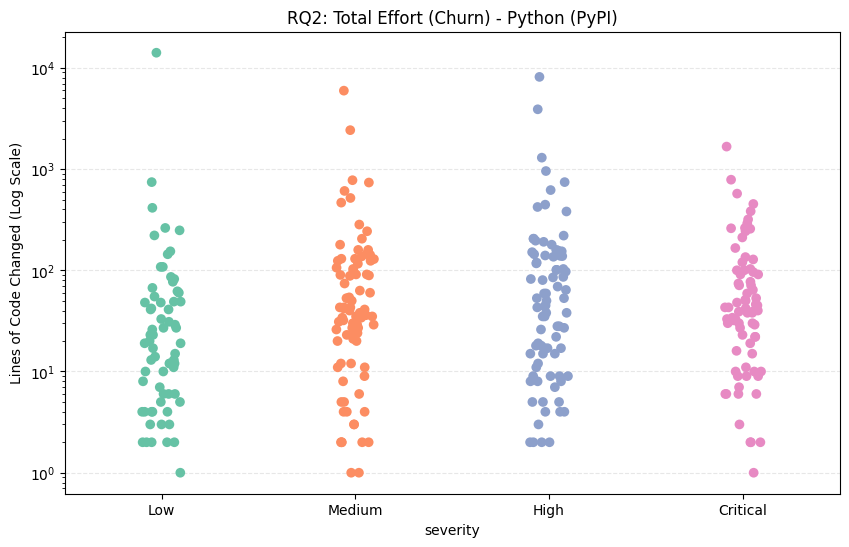

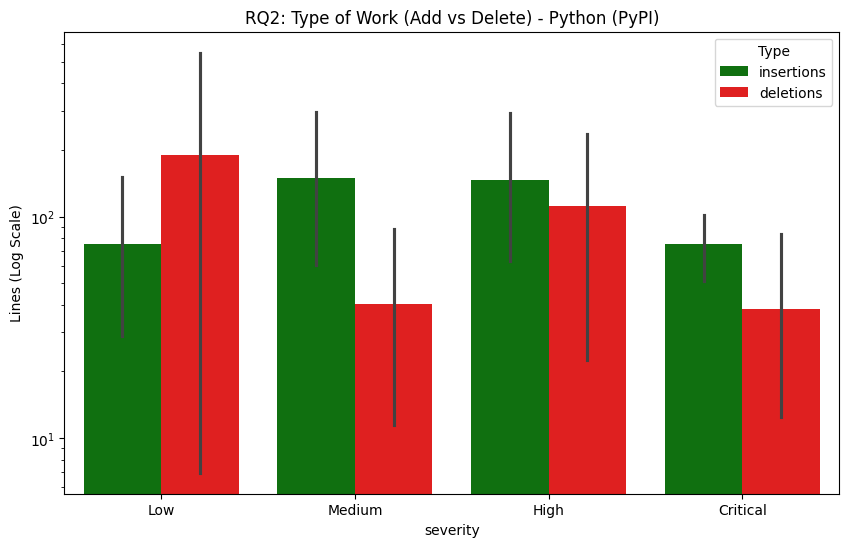

In [8]:
if results:
    df = pd.DataFrame(results)
    order = ['Low', 'Medium', 'High', 'Critical']
    
    print("\n" + "="*60)
    print(f"DETAIL ANALYSE FIXES: {ECOSYSTEM_NAME}")
    print("="*60)
    
    # We groeperen nu op severity en berekenen het gemiddelde van ALLES
    summary_table = df.groupby('severity')[['insertions', 'deletions', 'files_changed', 'churn']].mean().reindex(order)
    
    # Mooi printen (zonder decimalen voor regels code)
    print(summary_table.round(1))
    print("="*60)
    
    # --- PLOT 1: De Churn (zoals eerst) ---
    plt.figure(figsize=(10, 6))
    sns.stripplot(x='severity', y='churn', data=df, order=order, jitter=True, size=7, palette="Set2")
    plt.yscale('log') 
    plt.title(f'RQ2: Total Effort (Churn) - {ECOSYSTEM_NAME}')
    plt.ylabel('Lines of Code Changed (Log Scale)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    # --- PLOT 2 (NIEUW): Insertions vs Deletions ---
    # Dit laat zien: Wordt er vooral code geschreven (groen) of weggegooid (rood)?
    df_melt = df.melt(id_vars=['severity'], value_vars=['insertions', 'deletions'], var_name='Type', value_name='Lines')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='severity', y='Lines', hue='Type', data=df_melt, order=order, palette=['green', 'red'])
    plt.yscale('log')
    plt.title(f'RQ2: Type of Work (Add vs Delete) - {ECOSYSTEM_NAME}')
    plt.ylabel('Lines (Log Scale)')
    plt.show()

else:
    print("Geen data beschikbaar om te plotten.")